# Example Model Explanations with Seldon
Seldon core supports various out-of-the-box explainers that leverage the [Alibi ML Expalinability](https://github.com/SeldonIO/alibi) open source library.

In this notebook we show how you can use the pre-packaged explainer functionality that simplifies the creation of advanced AI model explainers.

Seldon provides the following out-of-the-box pre-packaged explainers:
* Anchor Tabular Explainer 
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for tabular data
    * It basically answers the question of what are the most "powerul" or "important" features in a tabular prediction
* Anchor Image Explainer
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for image data
    * It basically answers the question of what are the most "powerul" or "important" pixels in an image prediction
* Anchor Text Explainer
    * AI Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for text data
    * It basically answers the question of what are the most "powerul" or "important" tokens in a text prediction
* Counterfactual Explainer
    * AI Explainer that uses the [counterfactual technique](https://docs.seldon.io/projects/alibi/en/latest/methods/CF.html) for any type of data
    * It basically provides insight of what are the minimum changes you can do to an input to change the prediction to a different class
* Contrastive Explainer
    * AI explainer that uses the [Contrastive Explanations](https://docs.seldon.io/projects/alibi/en/latest/methods/CEM.html) technique for any type of data
    * It basically provides insights of what are the minimum changes you can do to an input to change the prediction to change the prediction or the minimum components of the input to make it the same prediction

## Running this notebook

For the [ImageNet Model](http://localhost:8888/notebooks/explainer_examples.ipynb#Imagenet-Model) you will need:

 - [alibi package](https://pypi.org/project/alibi/) (```pip install alibi```)
 
 This should install the required package dependencies, if not please also install:
 - [Pillow package](https://pypi.org/project/Pillow/) (```pip install Pillow```)
 - [matplotlib package](https://pypi.org/project/matplotlib/) (```pip install matplotlib```)
 - [tensorflow package](https://pypi.org/project/tensorflow/) (```pip install tensorflow```)

You will also need to start Jupyter with settings to allow for large payloads, for example:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000
```

## Setup Seldon Core

Follow the instructions to [Setup Cluster](seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](seldon_core_setup.ipynb#Install-Seldon-Core).

### Create Namespace for experimentation

We will first set up the namespace of Seldon where we will be deploying all our models

In [3]:
!kubectl create namespace seldon

namespace/seldon created


And then we will set the current workspace to use the seldon namespace so all our commands are run there by default (instead of running everything in the default namespace.)

In [4]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "docker-desktop" modified.


## Income Prediction Model

In [5]:
!pygmentize resources/income_explainer.yaml

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: income
spec:
  name: income
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/income/model
      name: classifier
    explainer:
      type: AnchorTabular
      modelUri: gs://seldon-models/sklearn/income/explainer
    name: default
    replicas: 1


In [6]:
!kubectl apply -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io/income created


In [7]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=income -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "income-default-0-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "income-default-0-classifier" successfully rolled out


In [8]:
!kubectl rollout status deploy/income-default-explainer

deployment "income-default-explainer" successfully rolled out


In [9]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:80")

Use python client library to get a prediction.

In [11]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
r = sc.predict(data=data)
print(r.response)

{'data': {'names': ['t:0', 't:1'], 'tensor': {'shape': [1, 2], 'values': [1.0, 0.0]}}, 'meta': {}}


Use curl to get a prediction.

In [15]:
!curl -d '{"data": {"ndarray":[[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]]}}' \
   -X POST http://localhost:8003/seldon/seldon/income/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1"],"ndarray":[[1.0,0.0]]},"meta":{}}


Use python client library to get an explanation.

In [26]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
explanation = sc.explain(deployment_name="income", predictor="default", data=data)
print(explanation.response["raw"]["examples"][0]["covered"][0])

http://localhost:80/seldon/seldon/income-explainer/default/api/v1.0/explain
dict
[21, 'Private', 'High School grad', 'Never-Married', 'Sales', 'Own-child', 'Black', 'Female', 'Capital Gain <= 0.00', 'Capital Loss <= 0.00', 25, 'United-States']


Using curl to get an explanation.

In [30]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]]}}' \
    http://localhost:80/seldon/seldon/income-explainer/default/api/v1.0/explain | jq ".raw.examples[0].covered[0]"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10175  100 10084  100    91  11698    105 --:--:-- --:--:-- --:--:-- 11790
[
  30,
  "Local-gov",
  "High School grad",
  "Separated",
  "Admin",
  "Unmarried",
  "White",
  "Female",
  "Capital Gain <= 0.00",
  "Capital Loss <= 0.00",
  40,
  "United-States"
]


In [31]:
!kubectl delete -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io "income" deleted


## Movie Sentiment Model



In [32]:
!pygmentize resources/moviesentiment_explainer.yaml

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: movie
spec:
  name: movie
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/moviesentiment
      name: classifier
    explainer:
      type: AnchorText
    name: default
    replicas: 1


In [33]:
!kubectl apply -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io/movie created


In [35]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=movie -o jsonpath='{.items[0].metadata.name}')

deployment "movie-default-0-classifier" successfully rolled out


In [36]:
!kubectl rollout status deploy/movie-default-explainer

deployment "movie-default-explainer" successfully rolled out


In [66]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="movie", namespace="seldon", gateway_endpoint="localhost:80", payload_type='ndarray')

In [52]:
!curl -d '{"data": {"ndarray":["This film has great actors"]}}' \
   -X POST http://localhost:80/seldon/seldon/movie/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1"],"ndarray":[[0.21266916924914636,0.7873308307508536]]},"meta":{}}


In [67]:
data = np.array(['this film has great actors'])
r = sc.predict(data=data)
print(r)
assert(r.success==True)

Success:True message:
Request:
meta {
}
data {
  ndarray {
    values {
      string_value: "this film has great actors"
    }
  }
}

Response:
{'data': {'names': ['t:0', 't:1'], 'ndarray': [[0.21266916924914636, 0.7873308307508536]]}, 'meta': {}}


In [63]:
!curl -s -d '{"data": {"ndarray":["This movie has great actors"]}}' \
   -X POST http://localhost:80/seldon/seldon/movie-explainer/default/api/v1.0/explain \
   -H "Content-Type: application/json" | jq ".raw.examples[0].covered[0]"

[
  "This UNK UNK great actors"
]


In [71]:
data = np.array(['this film has great actors'])
explanation = sc.explain(predictor="default", data=data)
print(explanation.response["raw"]["examples"][0]["covered"][0])

http://localhost:80/seldon/seldon/movie-explainer/default/api/v1.0/explain
dict
['this film UNK great UNK']


In [72]:
!kubectl delete -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io "movie" deleted


## Imagenet Model



In [75]:
!pygmentize resources/imagenet_explainer_grpc.yaml

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: image
spec:
  annotations:
    seldon.io/rest-timeout: "10000000"
    seldon.io/grpc-timeout: "10000000"
    seldon.io/grpc-max-message-size: "1000000000"
  name: image
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: docker.io/seldonio/imagenet-transformer:0.1
          name: transformer
    graph:
      name: transformer
      type: TRANSFORMER
      endpoint:
        type: GRPC
      children: 
      - implementation: TENSORFLOW_SERVER
        modelUri: gs://seldon-models/tfserving/imagenet/model
        name: classifier
        endpoint:
          type: GRPC
        parameters:
          - name: model_name
            type: STRING
            value: classifier
          - name: model_input
            type: STRING
            value: input_image
          - name: model_output
            type: STRING
            value: predictions/Softmax:0
    svcOrchSpec:
      resou

In [76]:
!kubectl apply -f resources/imagenet_explainer_grpc.yaml

seldondeployment.machinelearning.seldon.io/image created


In [77]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=image -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "image-default-0-transformer-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "image-default-0-transformer-classifier" successfully rolled out


In [78]:
!kubectl rollout status deploy/image-default-explainer

deployment "image-default-explainer" successfully rolled out


In [79]:
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    data = []
    image_shape = (299, 299, 3)
    target_size = image_shape[:2]
    image = Image.open("cat-raw.jpg").convert('RGB')
    image = np.expand_dims(image.resize(target_size), axis=0)
    data.append(image)
    data = np.concatenate(data, axis=0)
    return data

data = get_image_data()

In [91]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(
    deployment_name="image",
    namespace="seldon",
    grpc_max_send_message_length= 27 * 1024 * 1024,
    grpc_max_receive_message_length= 27 * 1024 * 1024, 
    gateway="ambassador",
    transport="grpc",
    gateway_endpoint="localhost:80",
    client_return_type='proto')

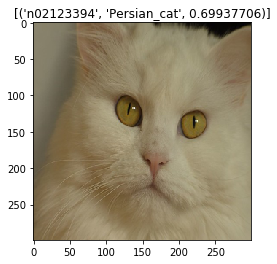

In [99]:
import tensorflow as tf
data = get_image_data()
req = data[0:1]
r = sc.predict(data=req, payload_type='tftensor')

preds = tf.make_ndarray(r.response.data.tftensor)

label = decode_predictions(preds, top=1)
plt.title(label[0])
plt.imshow(data[0])

http://localhost:80/seldon/seldon/image-explainer/default/api/v1.0/explain
dict


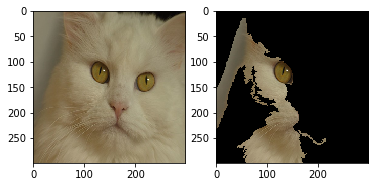

In [103]:
req = np.expand_dims(data[0], axis=0)
r = sc.explain(data=req, predictor="default", transport="rest", payload_type='ndarray', client_return_type="dict")
exp_arr = np.array(r.response['anchor'])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
axarr[1].imshow(r.response['anchor'])
plt.show()


In [ ]:
!kubectl delete -f resources/imagenet_explainer_grpc.yaml